In [1]:
import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import cv2, skimage
from IPython.display import clear_output

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
file = "/home/dsarkar/Documents/Study/BB LAB/C0120.MP4" # The file that will be analysed

cam = cv2.VideoCapture(file)

currentframe = 0
fps = 120
initialtime = 0 # Initial Time mentioned in seconds
length = 60 #Length of the clip to be analysed mentioned in seconds
skip = 15 #Number of frames to skip
data = []
num = []
property_id = int(cv2.CAP_PROP_FRAME_COUNT)  
leng = int(cv2.VideoCapture.get(cam, property_id))

cam.set(cv2.CAP_PROP_POS_FRAMES, int(initialtime*fps))
counter = 0
rad = []
while currentframe <= length*120:
    ret,frame = cam.read()
    cam.set(cv2.CAP_PROP_POS_FRAMES, int((initialtime*fps) + currentframe)-1)

    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        crop_img = gray
        circles = cv2.HoughCircles(crop_img, cv2.HOUGH_GRADIENT, 0.001, 18, param1=60, param2=6, minRadius=9, maxRadius=10)
        circles = circles[0, :]
        num.append(len(circles))
        for c in circles:
            #crop_img=cv2.circle(crop_img, (int(c[0]),int(c[1])), int(c[2]), (0,0,255), 1)
            rad.append(int(c[2]))
            data.append({'y':c[1], 'x':c[0] , 'frame':counter})
        #cv2.imshow("Frame", crop_img)
        #k = cv2.waitKey(1)
        #if k == 113:
        #    break
        #if currentframe == 10:
        #    gray1 = crop_img
        print(round((currentframe/(length*fps))*100))
        clear_output(wait=True)
    currentframe += skip
    counter += 1
    

100


In [3]:
# Track the bubbles with a memory of 10 frames using trackpy
features = pd.DataFrame(data)
cam.release()
cv2.destroyAllWindows()
t = tp.link_df(features, 2, memory=10)
del data
del features

Frame 480: 3141 trajectories present.


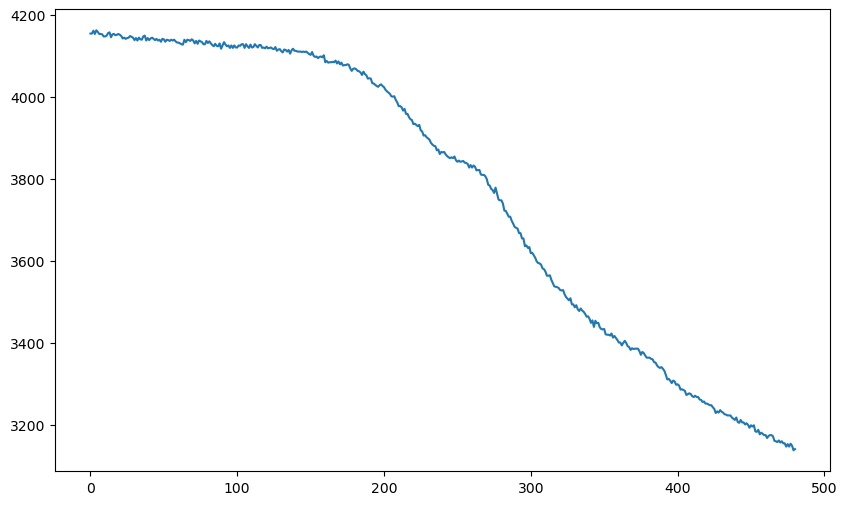

0
Before: 174270
After: 41734


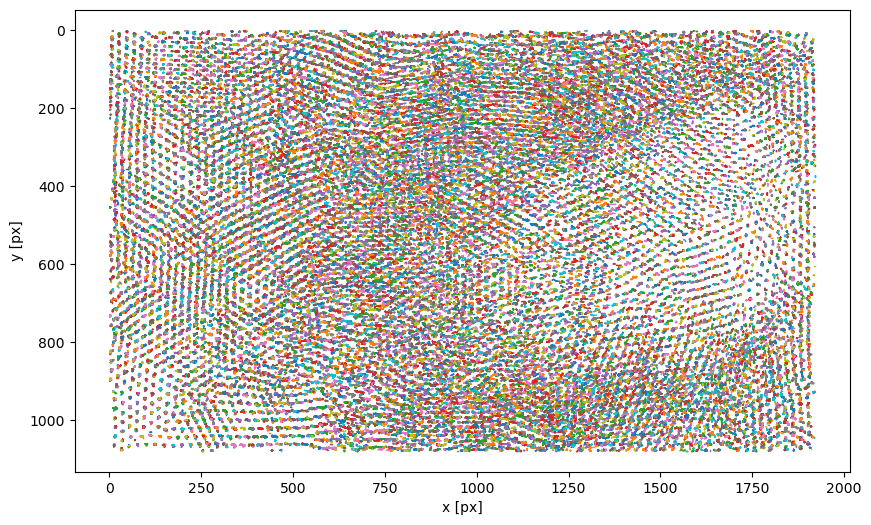

9.0


In [4]:
plt.plot(range(len(num)),num)
plt.show()

N_0 = num[0]
t_h = 0
for i in range(len(num)):
    if num[i] <= N_0//2:
        print('T 1/2 assigned')
        t_h = i
        break
    else:
        pass
print(t_h)

# Remove spurious tracked particles that do not survive for more than 10 frames
t1 = tp.filter_stubs(t,10)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

plt.figure()
tp.plot_traj(t1);

#t2 = t1[t1.particle.duplicated(keep=False)].sort_values("particle")
#t2.index.names = ['ID']
#t2 = t2.reset_index()

def avg(x):
    s = 0
    for i in x:
        s+=i
    return s/len(x)
# Calculating average radius of bubbles
radius = avg(rad)
print(radius)

In [17]:
t1.columns = ['y','x','frames','particle']
t2=t1

So now, there are two things that are to be done - 
- [-] Process a dict that has the keys as the bubble ids, and the value as the frame in which it bursts
- [-] Find a function that can find and return the IDs of the closest neighbours of the bubbles

In [46]:
# This function finds the closest 6 neighbouring bubble ids at a particular frame
def neighbour(id,frame):
    global t2
    global radius
    t4 = t2.loc[(t2['particle'] == id)&(t2['frames']==frame)]
    if list(t4['y']) == []:
        return 0
    t4 = dict(t4)
    #print(t4)
    y = int(t4['y'])
    x = int(t4['x'])
    t5 = t2.loc[(t2['x']<x+radius*3)&(t2['y']<y+radius*3)&(t2['x']>x-radius*3)&(t2['y']>y-radius*3)&(t2['frames']==frame)&(t2['particle']!=id)]
    return list(t5['particle'])

In [40]:
list(dict(t2.loc[(t2['particle'] == 2000)&(t2['frames']==1)])['y'])

[]

In [41]:
neighbour(2000,1)

0

In [44]:
# Creates a dictionary where the keys are the bubble ids and the values are the frame no. in which they burst
no = t2['particle'].nunique()
bursts = dict()
for i in range(no):
    t3 = t2.loc[t2['particle']==i].sort_values('frames')
    try:
        #print(int(t3.tail(1).frame))
        bursts[i] = int(t3.tail(1).frames)
    except:
        pass

In [51]:
# Intermediate Avalanche size detection for the video data
# This finds the total avalanche size of all the avalanches in a given frame
for i in range(167,counter -1):
    av = 0
    bur = [k for k, v in bursts.items() if v == i]
    #print(len(bur))
    for j in bur:
        neigh = neighbour(j,i)
        for x in neigh:
            try:
                if int(bursts[x] - i) == 1: # Change this value to affect relaxation threshold
                    av+=1
                    #bur.append(x)
                    #print('cooperative')
                else:
                    pass
            except:
                pass
    print('Total avalanche size -> ', av,' at time '+str(i*skip*(1/fps)))

Total avalanche size ->  14  at time 20.875
Total avalanche size ->  8  at time 21.0
Total avalanche size ->  27  at time 21.125
Total avalanche size ->  19  at time 21.25
Total avalanche size ->  77  at time 21.375
Total avalanche size ->  137  at time 21.5
Total avalanche size ->  44  at time 21.625
Total avalanche size ->  12  at time 21.75
Total avalanche size ->  5  at time 21.875
Total avalanche size ->  24  at time 22.0
Total avalanche size ->  25  at time 22.125
Total avalanche size ->  38  at time 22.25
Total avalanche size ->  21  at time 22.375
Total avalanche size ->  6  at time 22.5
Total avalanche size ->  4  at time 22.625
Total avalanche size ->  8  at time 22.75
Total avalanche size ->  22  at time 22.875
Total avalanche size ->  26  at time 23.0
Total avalanche size ->  20  at time 23.125
Total avalanche size ->  26  at time 23.25
Total avalanche size ->  38  at time 23.375
Total avalanche size ->  12  at time 23.5
Total avalanche size ->  2  at time 23.625
Total aval